In [16]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "5"
import os.path as path
from copy import copy
import numpy as np

from joblib import Parallel, delayed

from ExperimentConfig import ExperimentConfig
from Experiment import Experiment
from CombinedExperiment import CombinedExperiment
from typing import List
from Experiment import RaceResult

class ComparisonResult:
    def __init__(self, results: List[RaceResult]):
        self.results = results

base_config = ExperimentConfig("base_config",
                         "IRV",
                         equal_pct_bins=True,
                         candidate_variance=.5,
                         quality_variance=0,
                         ideology_flexibility = .7,
                         sampling_voters=1000,
                         model_path="none")

def run_strategic_race(config: ExperimentConfig) -> RaceResult:
    import random
    x = Experiment(config)
    # np.random.seed(17)
    # random.seed(17)
    return x.run_strategic_race()

def compute_SUE_single(rr: RaceResult):
    return CombinedExperiment.compute_SUE_single(rr)

import matplotlib.pyplot as plt
def make_line_plot(data, title, labels,
                   xlabel: str = "Candidate Ideological Flexibility (stddev)",
                   ylabel: str = "Social Utility Efficiency"):
    import matplotlib as mpl
    mpl.rcParams['figure.dpi'] = 300
    n_rows = 1
    n_cols = 1
    fig, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))
    fig.suptitle(title, color="black", fontsize=22)
    fig.set_facecolor("white")

    count = 0
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    axis.tick_params(axis='x', colors="black")

    for i in range(len(data)):
        d = data[i]
        plt.plot(d[0], d[1], label =labels[i])
    plt.legend()

    axis.set_xlabel(xlabel, fontsize=20)
    axis.set_ylabel(ylabel, fontsize=20)


In [17]:
def run_races(n_races: int, qv: float, flex: float):
    training_iterations = 50000
    h2h_config = copy(base_config)
    h2h_config.election_name="H2H"
    # h2h_config.model_path = "exp/v26/H2H-A.mdl.%06d.progress" % (training_iterations )
    h2h_config.model_path = "exp/v10/H2H.mdl"
    h2h_config.sampling_voters = 1000
    h2h_config.quality_variance = qv
    h2h_config.ideology_flexibility = flex

    results: List[List[RaceResult]] = Parallel(n_jobs=32)(
        delayed(run_strategic_race)(h2h_config) for _ in range(n_races))
    return results

def count_ties(rr: List[RaceResult]) -> float:
    # for r in rr:
        # if r.condorcet_tie:
        #     print("tie")

    ties = [r for r in rr if r.condorcet_tie]
    return len(ties) / len(rr)

In [18]:
def sample_h2h():
    h2h_config = copy(base_config)
    h2h_config.election_name="H2H"
    # h2h_config.model_path = "exp/v26/H2H-A.mdl.%06d.progress" % (training_iterations )
    h2h_config.model_path = "exp/v10/H2H.mdl"
    h2h_config.sampling_voters = 1000
    h2h_config.quality_variance = 0
    h2h_config.ideology_flexibility = .7
    h2h_config.equal_pct_bins = True

    result = run_strategic_race(h2h_config)
    count_ties([result])
    return result
# sample_h2h()


In [19]:
flex_range = np.arange(0, 1.01, .1)
qv_range = np.arange(0, .21, .02)


n_races = 1000
flex_results = [run_races(n_races, 0, fx) for fx in flex_range]
qv_results = [run_races(n_races, qv, .7) for qv in qv_range]


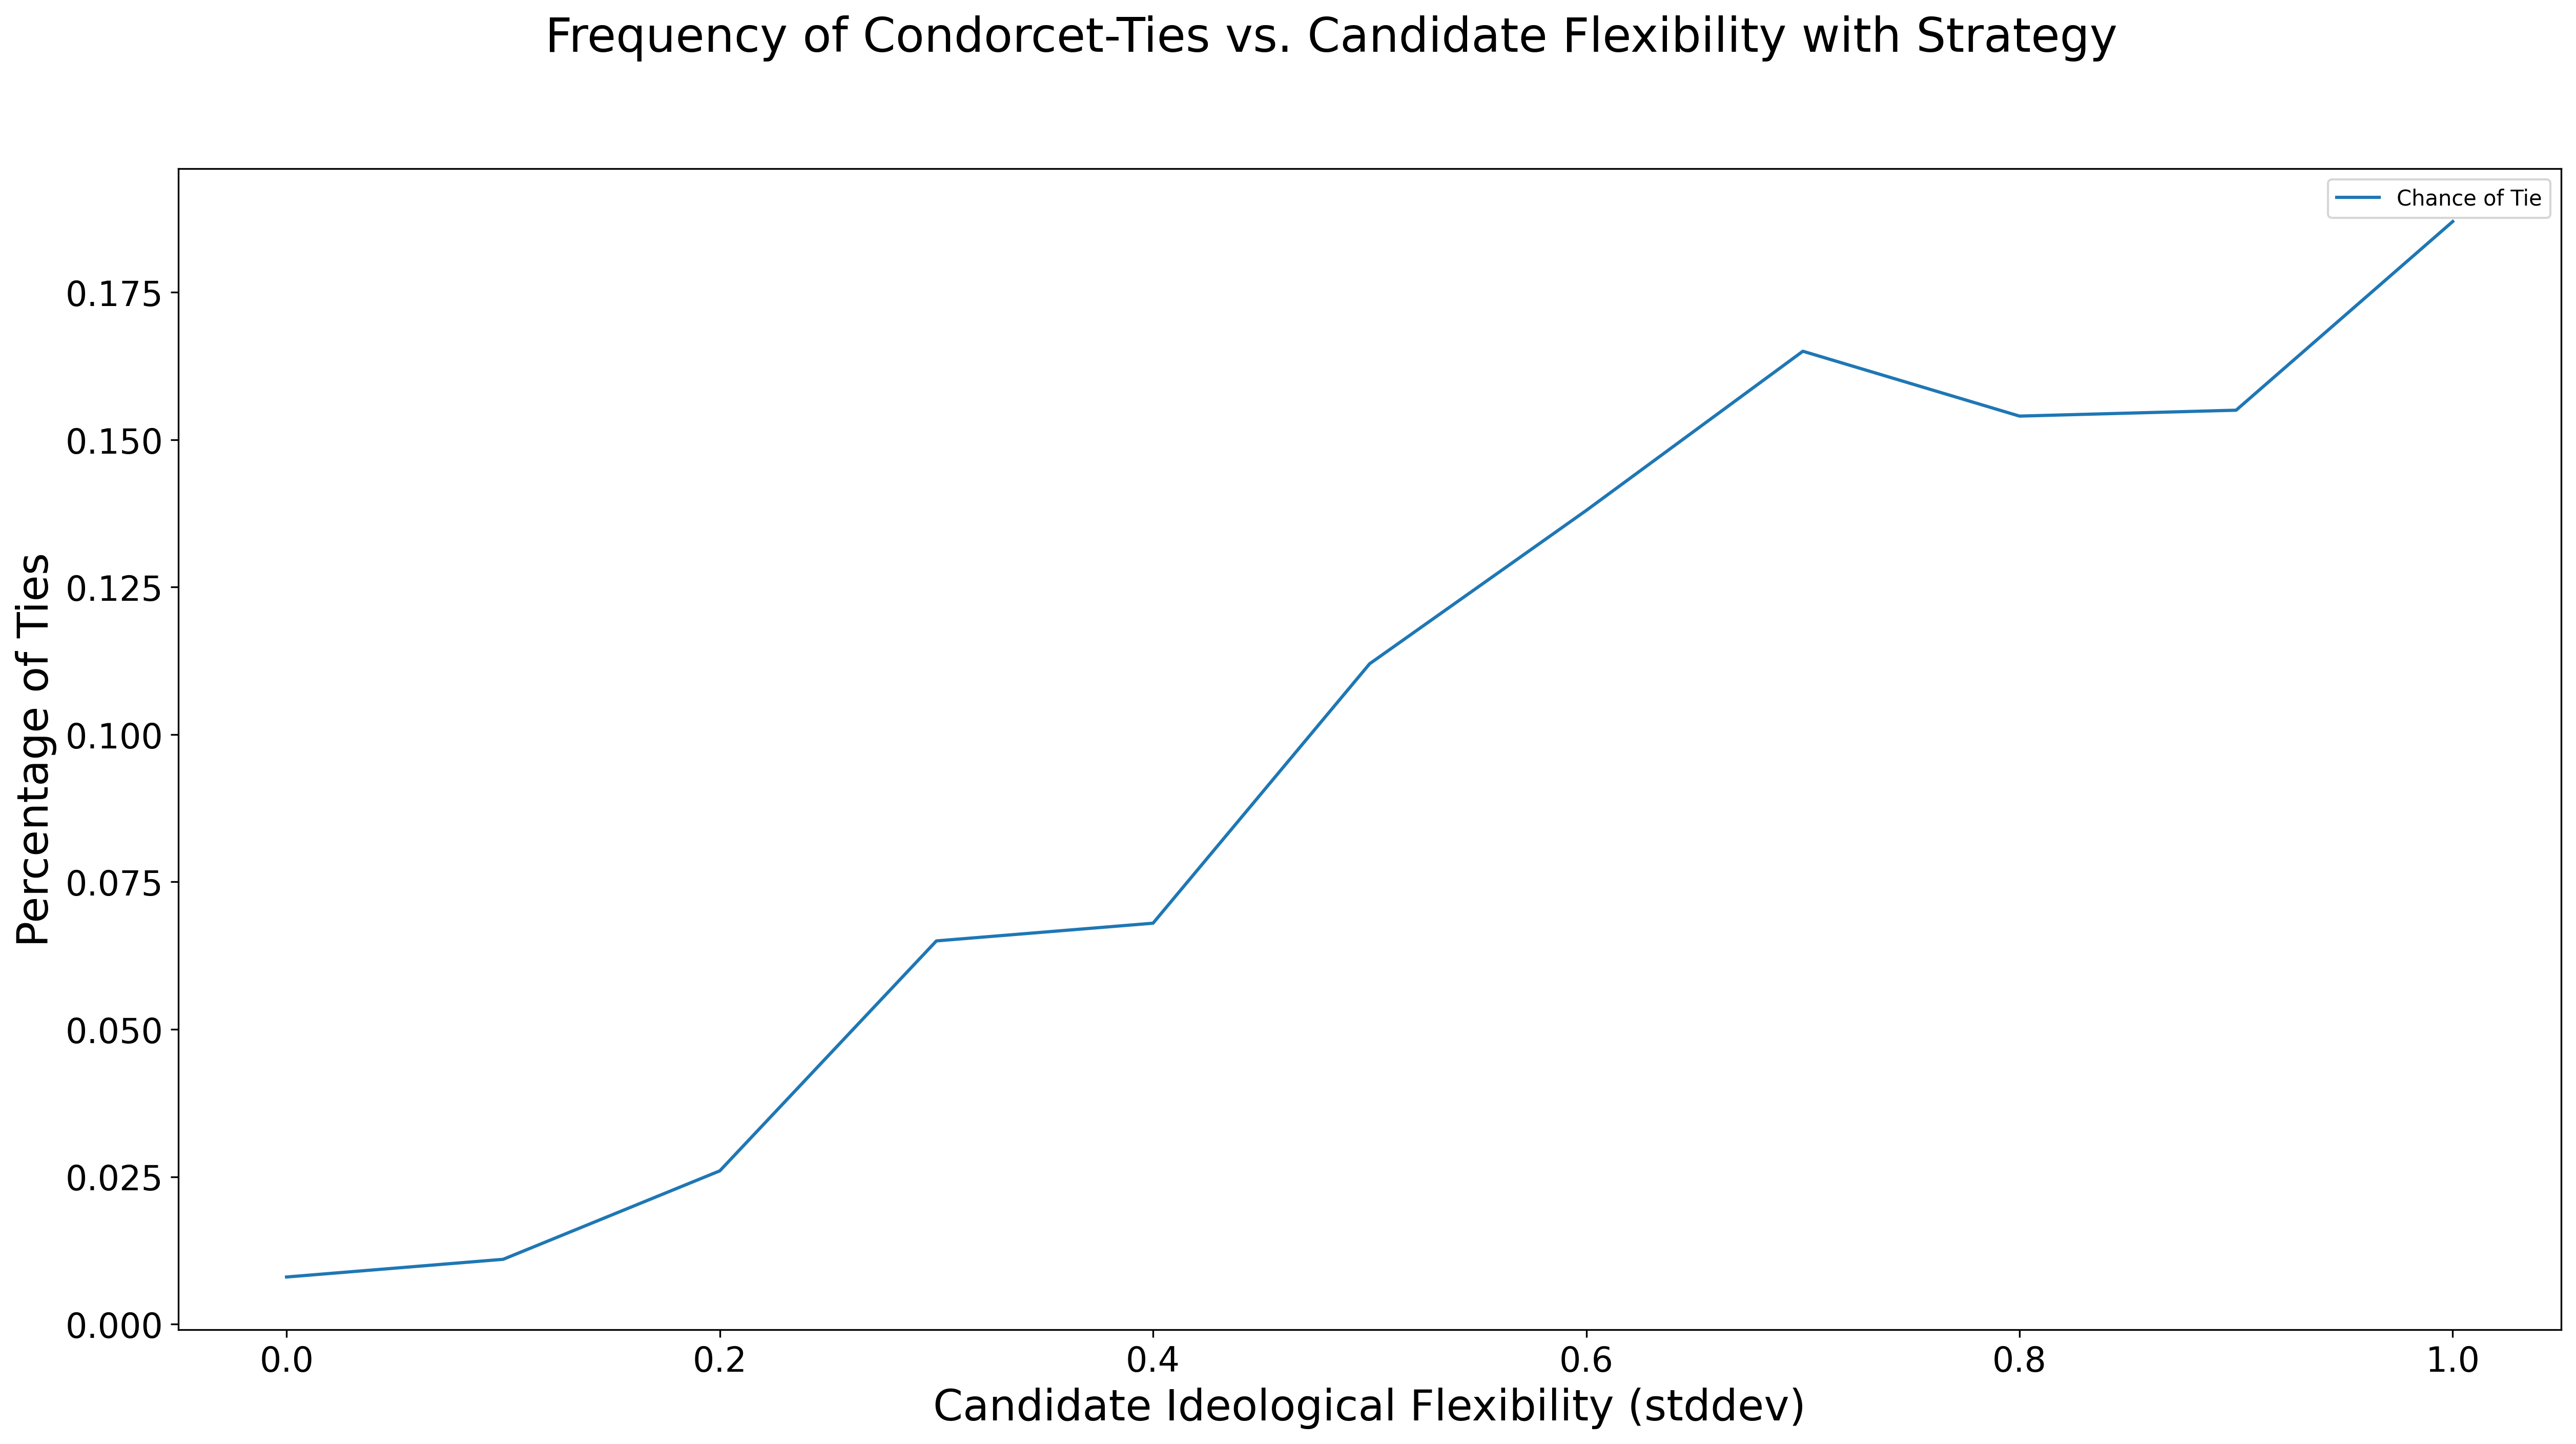

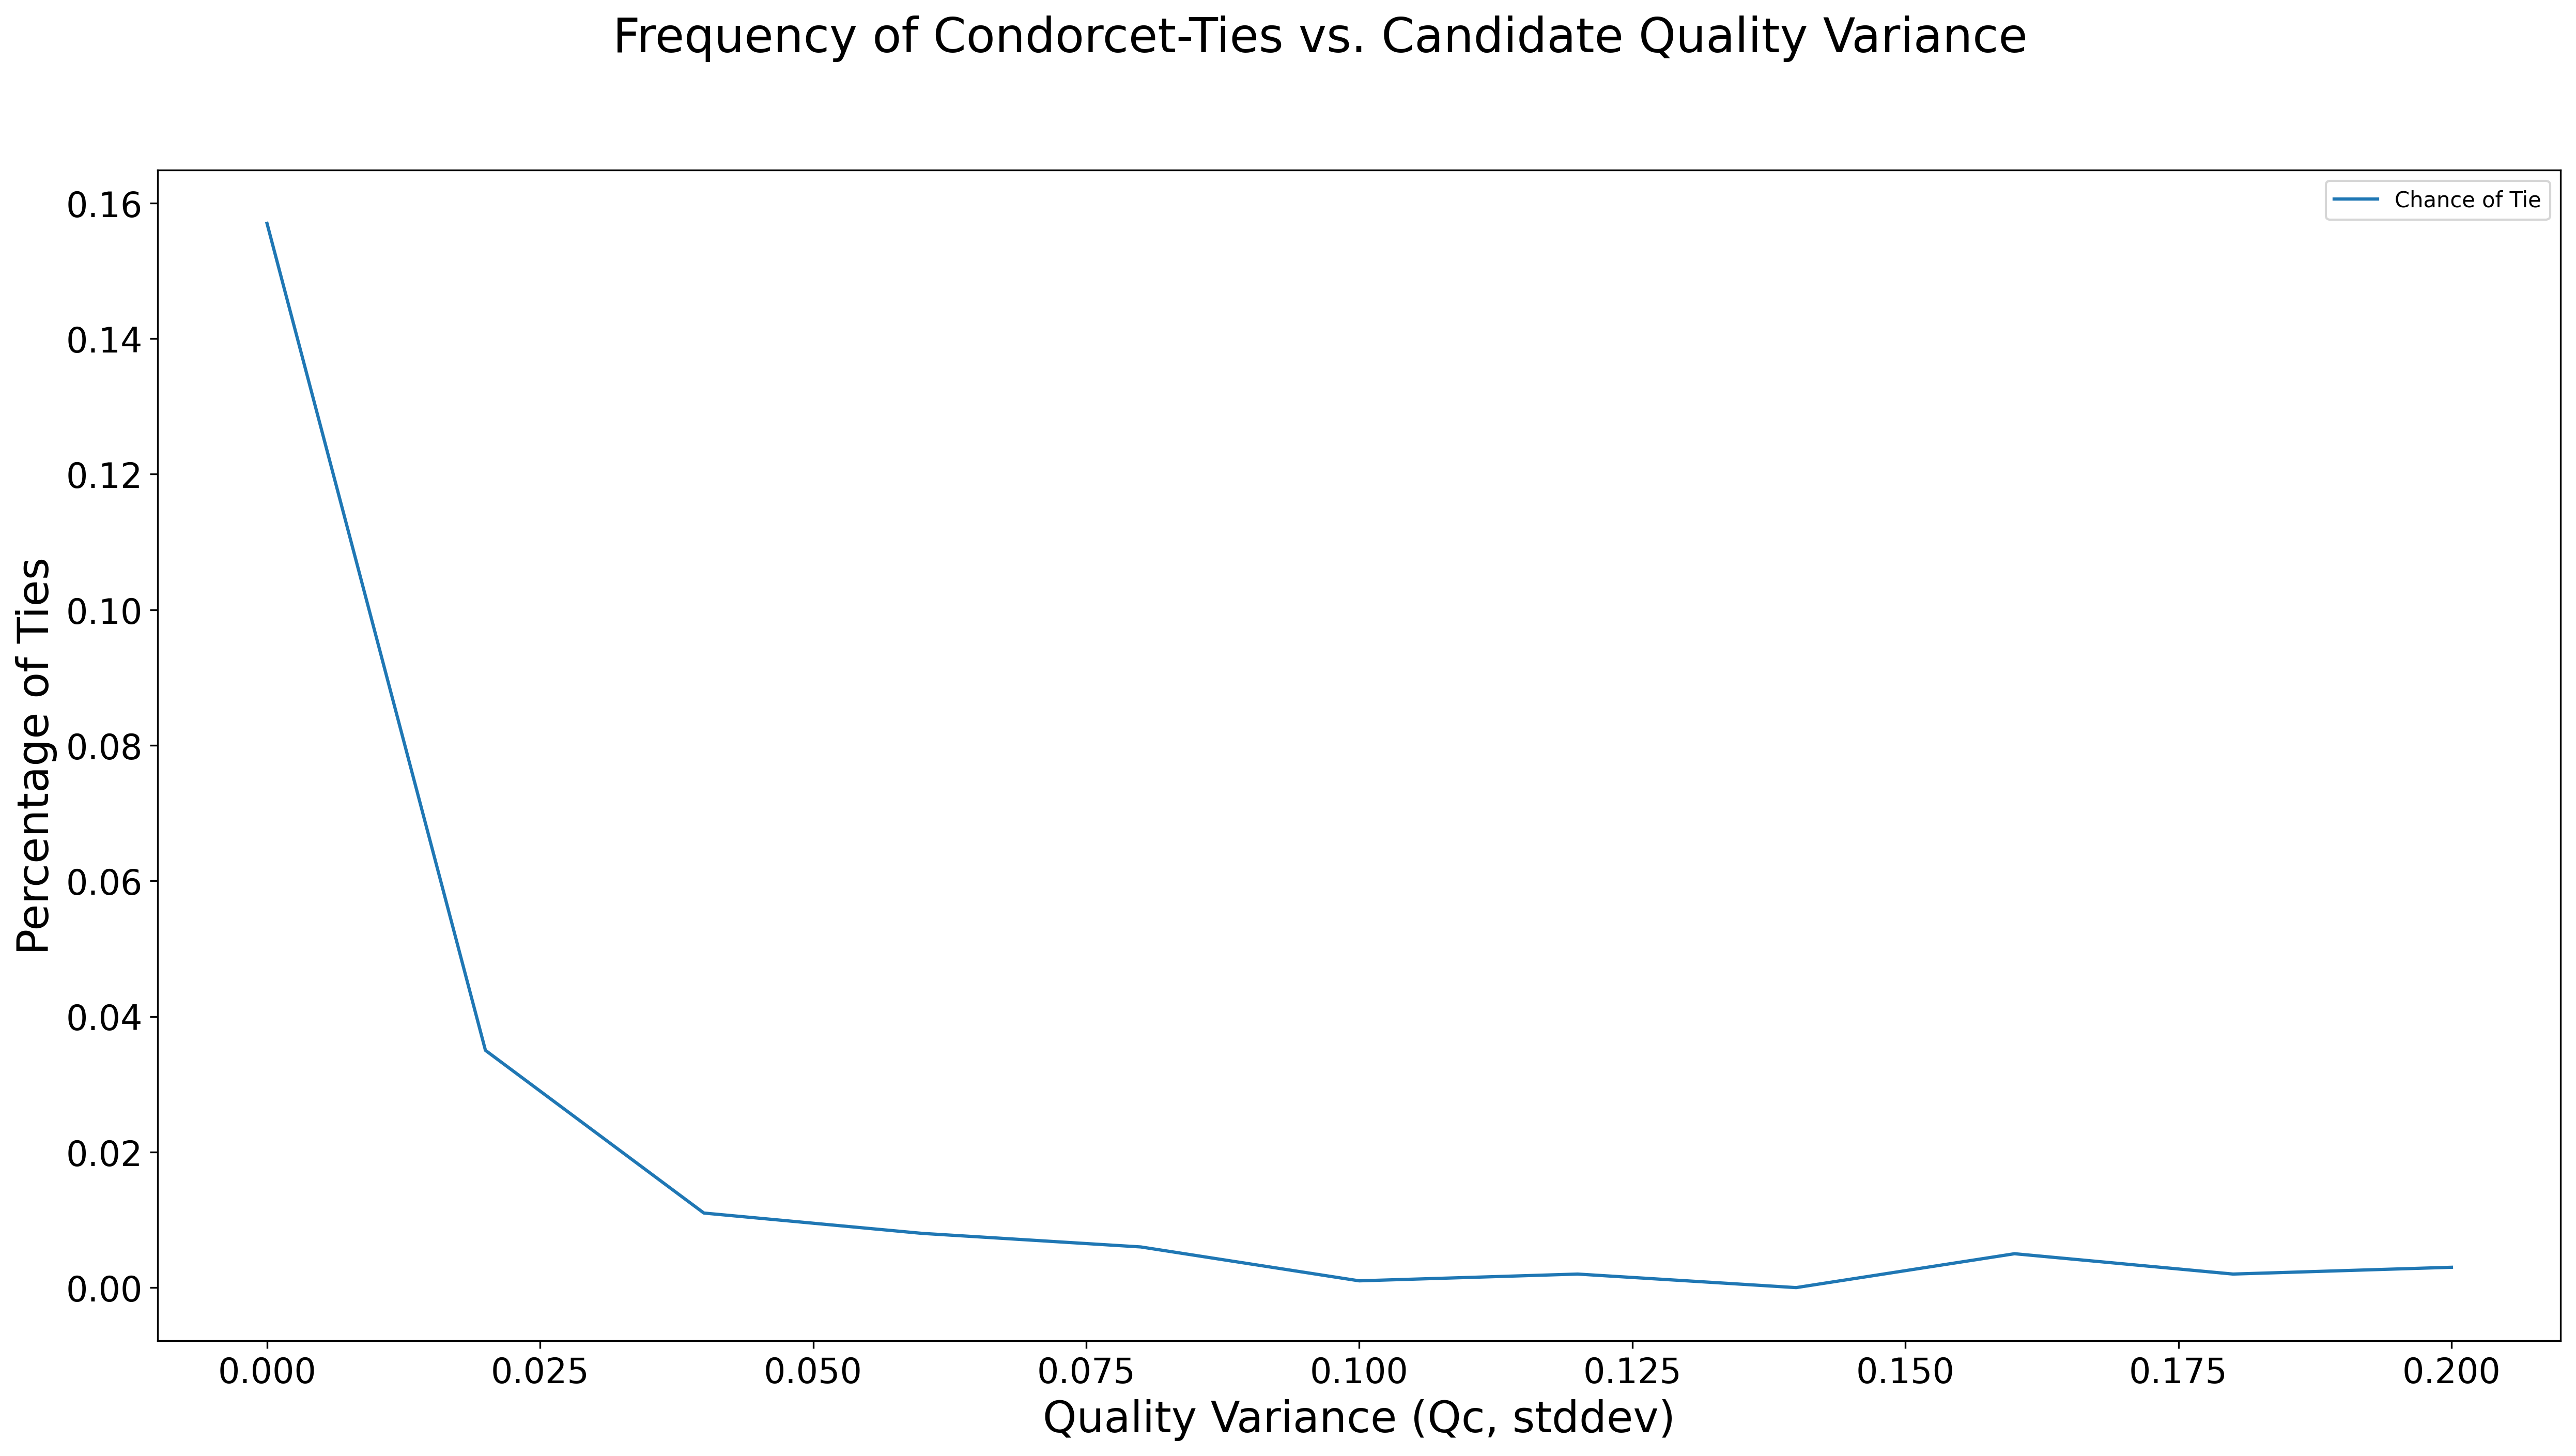

In [20]:
flex_ties = [count_ties(rr) for rr in flex_results]
qv_ties = [count_ties(rr) for rr in qv_results]



make_line_plot([[flex_range, flex_ties]],
               "Frequency of Condorcet-Ties vs. Candidate Flexibility with Strategy",
               ["Chance of Tie"],
               "Candidate Ideological Flexibility (stddev)",
               "Percentage of Ties")

make_line_plot([[qv_range, qv_ties]],
               "Frequency of Condorcet-Ties vs. Candidate Quality Variance",
               ["Chance of Tie"],
               "Quality Variance (Qc, stddev)",
               "Percentage of Ties")